# Лабораторная работа №3 - "Подбор гиперпараметров модели"

---

###### Выполнил: [Штыхно Илья]
###### Группа: [М8О-309Б]
###### Датасет: [Student Alcohol Consumption](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption)

---

## Описание задачи

**Цель:** Предсказать уровень употребления алкоголя студентами (высокий/низкий) на основе различных социально-демографических факторов.

**Тип задачи:** Бинарная классификация

**Целевая переменная:** `alcohol_level` - создадим на основе среднего значения `Dalc` (употребление алкоголя в будние дни) и `Walc` (употребление алкоголя в выходные):
- 0 - низкий уровень (среднее значение <= 2)
- 1 - высокий уровень (среднее значение > 2)

**Выбранная модель:** Random Forest Classifier

**Причины выбора:**
- Хорошо работает с категориальными и числовыми признаками
- Устойчив к переобучению
- Позволяет оценить важность признаков
- Имеет множество гиперпараметров для оптимизации

## 0. Импорт библиотек

In [8]:
# Установка необходимых библиотек
!pip install optuna -q
!pip install lime -q
!pip install shap -q

print("Все библиотеки установлены!")

Все библиотеки установлены!


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Установим seed для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Библиотеки успешно загружены!")

Библиотеки успешно загружены!


## 1. Гиперпараметры модели Random Forest

Random Forest - это ансамблевый метод машинного обучения, который строит множество деревьев решений и объединяет их предсказания.

### Основные гиперпараметры:

| Гиперпараметр | Описание | Возможные значения | Влияние на модель |
|---------------|----------|-------------------|-------------------|
| `n_estimators` | Количество деревьев в лесу | 50, 100, 200, 300, 500 | Больше деревьев - лучше качество, но медленнее |
| `max_depth` | Максимальная глубина дерева | 5, 10, 15, 20, None | Глубокие деревья могут переобучаться |
| `min_samples_split` | Минимальное число образцов для разбиения узла | 2, 5, 10, 15 | Больше значение - проще модель |
| `min_samples_leaf` | Минимальное число образцов в листе | 1, 2, 4, 8 | Больше значение - менее детальная модель |
| `max_features` | Число признаков для поиска лучшего разбиения | 'sqrt', 'log2', None | Влияет на разнообразие деревьев |
| `bootstrap` | Использовать ли bootstrap выборки | True, False | True - каждое дерево обучается на подвыборке |
| `criterion` | Функция для оценки качества разбиения | 'gini', 'entropy' | Метрика оценки узлов дерева |
| `class_weight` | Веса классов | None, 'balanced' | 'balanced' помогает при несбалансированных данных |

## 2. Загрузка и подготовка данных

In [10]:
# Загрузка датасета
df = pd.read_csv('student-mat.csv')

print(f"Размер датасета: {df.shape}")
print(f"\nПервые 5 строк:")
df.head()

Размер датасета: (395, 33)

Первые 5 строк:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [11]:
# Информация о данных
print("Информация о датасете:")
df.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null   

In [12]:
# Описательная статистика
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


### Создание целевой переменной

In [13]:
# Создаем целевую переменную на основе среднего употребления алкоголя
df['avg_alcohol'] = (df['Dalc'] + df['Walc']) / 2
df['alcohol_level'] = (df['avg_alcohol'] > 2).astype(int)

print("Распределение целевой переменной:")
print(df['alcohol_level'].value_counts())
print(f"\nПроцентное соотношение:")
print(df['alcohol_level'].value_counts(normalize=True) * 100)

Распределение целевой переменной:
alcohol_level
0    276
1    119
Name: count, dtype: int64

Процентное соотношение:
alcohol_level
0    69.873418
1    30.126582
Name: proportion, dtype: float64


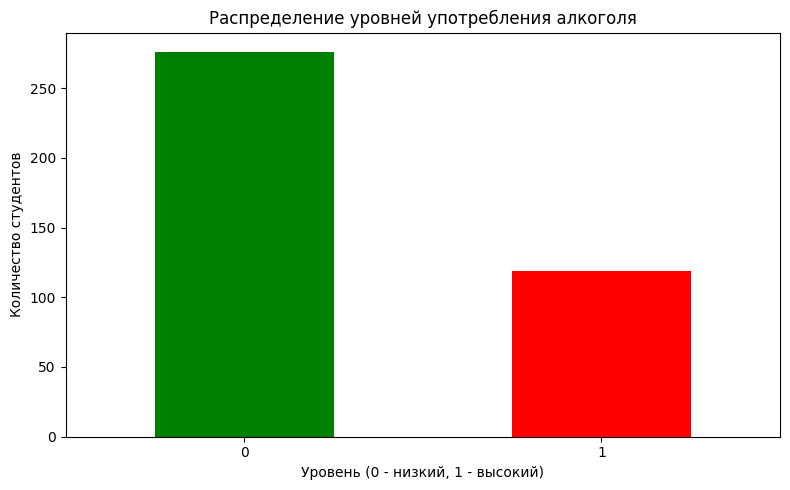

In [14]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(8, 5))
df['alcohol_level'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение уровней употребления алкоголя')
plt.xlabel('Уровень (0 - низкий, 1 - высокий)')
plt.ylabel('Количество студентов')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Предобработка признаков

In [15]:
# Удаляем служебные колонки, которые использовали для создания целевой переменной
df_processed = df.drop(['Dalc', 'Walc', 'avg_alcohol'], axis=1)

# Кодирование категориальных признаков
categorical_columns = df_processed.select_dtypes(include=['object']).columns

print(f"Категориальные признаки: {list(categorical_columns)}")

# Label Encoding для категориальных признаков
le = LabelEncoder()
for col in categorical_columns:
    df_processed[col] = le.fit_transform(df_processed[col])

print("\nКодирование завершено!")

Категориальные признаки: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Кодирование завершено!


In [16]:
# Разделение на признаки и целевую переменную
X = df_processed.drop('alcohol_level', axis=1)
y = df_processed['alcohol_level']

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")
print(f"\nПризнаки: {list(X.columns)}")

Размерность признаков: (395, 31)
Размерность целевой переменной: (395,)

Признаки: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3']


In [17]:
# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в train:")
print(y_train.value_counts())
print(f"\nРаспределение классов в test:")
print(y_test.value_counts())

Размер обучающей выборки: (316, 31)
Размер тестовой выборки: (79, 31)

Распределение классов в train:
alcohol_level
0    221
1     95
Name: count, dtype: int64

Распределение классов в test:
alcohol_level
0    55
1    24
Name: count, dtype: int64


## 3. Подбор гиперпараметров

### 3.1 Grid Search

Grid Search перебирает все возможные комбинации заданных гиперпараметров и выбирает лучшую по метрике качества.

In [18]:
# Определение сетки гиперпараметров для Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

print("Параметры для Grid Search:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nОбщее количество комбинаций: {total_combinations}")

Параметры для Grid Search:
  n_estimators: [100, 200, 300]
  max_depth: [10, 15, 20, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']
  criterion: ['gini', 'entropy']

Общее количество комбинаций: 432


In [ ]:
# Grid Search
print("Запуск Grid Search...\n")

rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\n" + "="*50)
print("Grid Search завершен!")
print("="*50)

Запуск Grid Search...

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [ ]:
# Результаты Grid Search
print("\nЛучшие параметры (Grid Search):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nЛучший F1-score на кросс-валидации: {grid_search.best_score_:.4f}")

# Оценка на тестовой выборке
y_pred_grid = grid_search.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
f1_grid = f1_score(y_test, y_pred_grid)

print(f"Accuracy на тесте: {accuracy_grid:.4f}")
print(f"F1-score на тесте: {f1_grid:.4f}")


Лучшие параметры (Grid Search):
  criterion: entropy
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 100

Лучший F1-score на кросс-валидации: 0.4820
Accuracy на тесте: 0.7722
F1-score на тесте: 0.5000


### 3.2 Random Search

Random Search случайным образом выбирает комбинации гиперпараметров из заданных распределений.

In [ ]:
# Определение распределений для Random Search
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

print("Параметры для Random Search:")
for param, values in param_distributions.items():
    if hasattr(values, 'args'):
        low, high = values.args
        print(f"  {param}: randint({low}, {high}) -> диапазон [{low}, {high})")
    else:
        print(f"  {param}: {values}")

Параметры для Random Search:
  n_estimators: randint(50, 500) -> диапазон [50, 500)
  max_depth: [10, 15, 20, 25, 30, None]
  min_samples_split: randint(2, 20) -> диапазон [2, 20)
  min_samples_leaf: randint(1, 10) -> диапазон [1, 10)
  max_features: ['sqrt', 'log2', None]
  criterion: ['gini', 'entropy']


In [ ]:
# Random Search
print("Запуск Random Search...\n")

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=100,  # количество случайных комбинаций
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

random_search.fit(X_train, y_train)

print("\n" + "="*50)
print("Random Search завершен!")
print("="*50)

Запуск Random Search...

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Random Search завершен!


In [ ]:
# Результаты Random Search
print("\nЛучшие параметры (Random Search):")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nЛучший F1-score на кросс-валидации: {random_search.best_score_:.4f}")

# Оценка на тестовой выборке
y_pred_random = random_search.predict(X_test)
accuracy_random = accuracy_score(y_test, y_pred_random)
f1_random = f1_score(y_test, y_pred_random)

print(f"Accuracy на тесте: {accuracy_random:.4f}")
print(f"F1-score на тесте: {f1_random:.4f}")


Лучшие параметры (Random Search):
  criterion: gini
  max_depth: None
  max_features: None
  min_samples_leaf: 9
  min_samples_split: 6
  n_estimators: 274

Лучший F1-score на кросс-валидации: 0.5398
Accuracy на тесте: 0.7848
F1-score на тесте: 0.4848


### 3.3 Optuna

Optuna использует байесовскую оптимизацию для эффективного поиска оптимальных гиперпараметров.

In [ ]:
# Определение objective функции для Optuna
def objective(trial):
    # Определяем пространство поиска гиперпараметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': RANDOM_STATE
    }
    
    # Создаем модель с предложенными параметрами
    model = RandomForestClassifier(**params)
    
    # Кросс-валидация
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score

In [ ]:
# Создание исследования Optuna
print("Запуск Optuna...\n")

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

print("\n" + "="*50)
print("Optuna завершена!")
print("="*50)

[I 2025-11-17 22:25:57,168] A new study created in memory with name: no-name-9c5e8dcf-2ff3-4483-9bd9-952be60781a9


Запуск Optuna...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-17 22:25:58,449] Trial 1 finished with value: 0.38485467278570723 and parameters: {'n_estimators': 166, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.38485467278570723.
[I 2025-11-17 22:25:58,900] Trial 3 finished with value: 0.5281661783487341 and parameters: {'n_estimators': 455, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': None, 'criterion': 'entropy'}. Best is trial 3 with value: 0.5281661783487341.
[I 2025-11-17 22:25:59,030] Trial 5 finished with value: 0.39349206349206345 and parameters: {'n_estimators': 324, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 3 with value: 0.5281661783487341.
[I 2025-11-17 22:25:59,410] Trial 2 finished with value: 0.38803418803418804 and parameters: {'n_estimators': 280, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5

In [ ]:
# Результаты Optuna
print("\nЛучшие параметры (Optuna):")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

print(f"\nЛучший F1-score на кросс-валидации: {study.best_value:.4f}")

# Обучаем модель с лучшими параметрами
best_model_optuna = RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE)
best_model_optuna.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred_optuna = best_model_optuna.predict(X_test)
accuracy_optuna = accuracy_score(y_test, y_pred_optuna)
f1_optuna = f1_score(y_test, y_pred_optuna)

print(f"Accuracy на тесте: {accuracy_optuna:.4f}")
print(f"F1-score на тесте: {f1_optuna:.4f}")


Лучшие параметры (Optuna):
  n_estimators: 239
  max_depth: 23
  min_samples_split: 11
  min_samples_leaf: 10
  max_features: None
  criterion: gini

Лучший F1-score на кросс-валидации: 0.5469
Accuracy на тесте: 0.7848
F1-score на тесте: 0.4848


## 4. Сравнение методов подбора гиперпараметров

In [ ]:
# Создание таблицы сравнения
results_df = pd.DataFrame({
    'Метод': ['Grid Search', 'Random Search', 'Optuna'],
    'F1-score (CV)': [
        grid_search.best_score_,
        random_search.best_score_,
        study.best_value
    ],
    'Accuracy (Test)': [
        accuracy_grid,
        accuracy_random,
        accuracy_optuna
    ],
    'F1-score (Test)': [
        f1_grid,
        f1_random,
        f1_optuna
    ]
})

print("\n" + "="*70)
print("СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)


СРАВНЕНИЕ МЕТОДОВ ПОДБОРА ГИПЕРПАРАМЕТРОВ
        Метод  F1-score (CV)  Accuracy (Test)  F1-score (Test)
  Grid Search       0.481962         0.772152         0.500000
Random Search       0.539759         0.784810         0.484848
       Optuna       0.546854         0.784810         0.484848


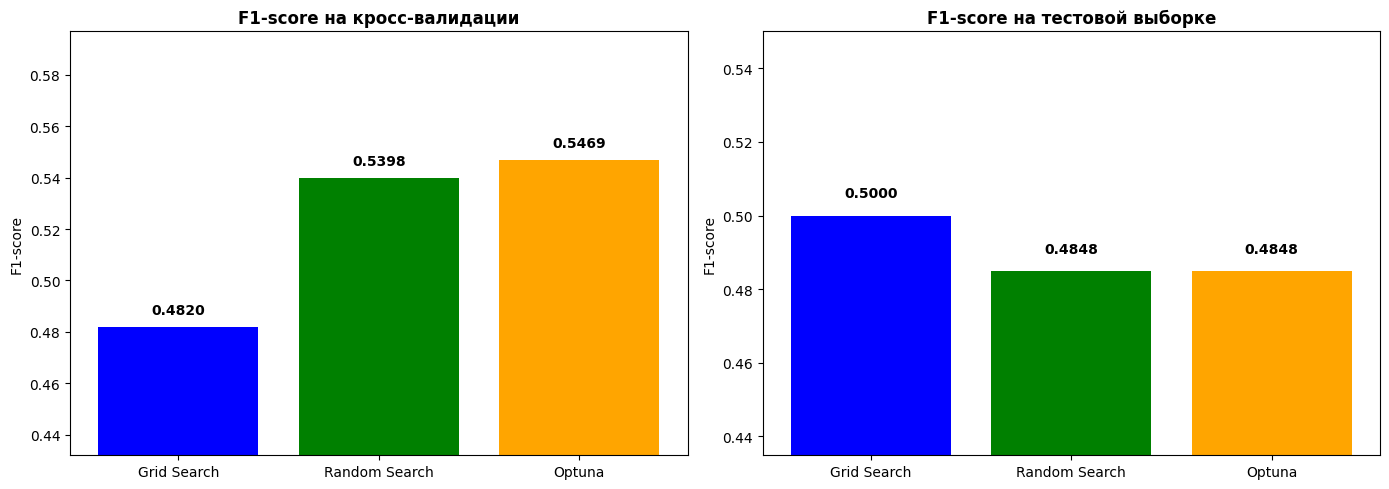

In [ ]:
# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1-score на CV
axes[0].bar(results_df['Метод'], results_df['F1-score (CV)'], color=['blue', 'green', 'orange'])
axes[0].set_title('F1-score на кросс-валидации', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1-score')
axes[0].set_ylim([min(results_df['F1-score (CV)']) - 0.05, max(results_df['F1-score (CV)']) + 0.05])
for i, v in enumerate(results_df['F1-score (CV)']):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# F1-score на Test
axes[1].bar(results_df['Метод'], results_df['F1-score (Test)'], color=['blue', 'green', 'orange'])
axes[1].set_title('F1-score на тестовой выборке', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1-score')
axes[1].set_ylim([min(results_df['F1-score (Test)']) - 0.05, max(results_df['F1-score (Test)']) + 0.05])
for i, v in enumerate(results_df['F1-score (Test)']):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Определяем лучший метод
best_method_idx = results_df['F1-score (Test)'].idxmax()
best_method = results_df.loc[best_method_idx, 'Метод']
best_f1 = results_df.loc[best_method_idx, 'F1-score (Test)']

print(f"\n Лучший метод: {best_method}")
print(f"   F1-score на тесте: {best_f1:.4f}")

# Выбираем лучшую модель для интерпретации
if best_method == 'Grid Search':
    best_model = grid_search.best_estimator_
    y_pred_best = y_pred_grid
elif best_method == 'Random Search':
    best_model = random_search.best_estimator_
    y_pred_best = y_pred_random
else:
    best_model = best_model_optuna
    y_pred_best = y_pred_optuna


 Лучший метод: Grid Search
   F1-score на тесте: 0.5000


## 5. Детальная оценка лучшей модели

In [ ]:
# Classification Report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['Низкий уровень', 'Высокий уровень']))


Classification Report:
                 precision    recall  f1-score   support

 Низкий уровень       0.78      0.95      0.85        55
Высокий уровень       0.75      0.38      0.50        24

       accuracy                           0.77        79
      macro avg       0.76      0.66      0.68        79
   weighted avg       0.77      0.77      0.75        79



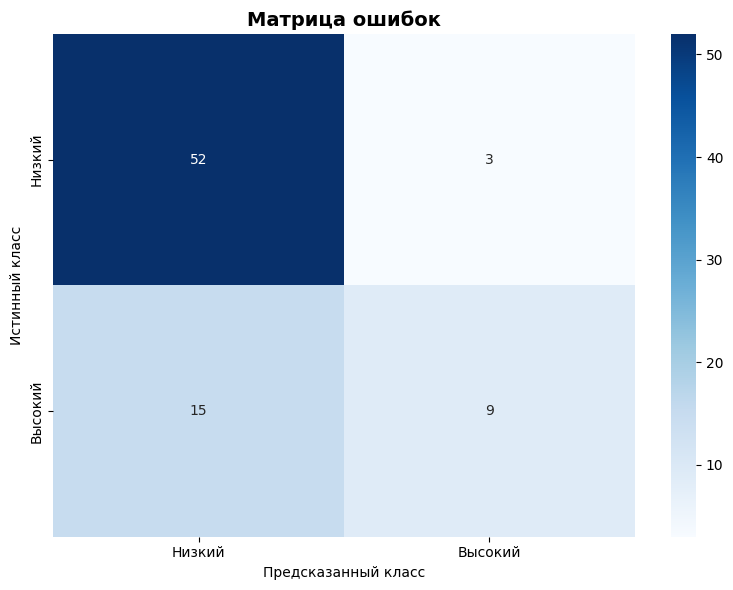

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Низкий', 'Высокий'],
            yticklabels=['Низкий', 'Высокий'])
plt.title('Матрица ошибок', fontsize=14, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

## 6. Интерпретация модели

In [ ]:
# Установка библиотеки LIME (если не установлена)
!pip install lime -q

In [ ]:
import lime
import lime.lime_tabular

# Создание LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Низкий уровень', 'Высокий уровень'],
    mode='classification',
    random_state=RANDOM_STATE
)

print("LIME explainer создан!")

LIME explainer создан!


In [ ]:
# Выводим информацию о выбранных студентах из исходных данных
print("\n" + "="*70)
print("ИНФОРМАЦИЯ О СТУДЕНТАХ ДЛЯ ИНТЕРПРЕТАЦИИ")
print("="*70)

# Получаем исходные индексы в полном датасете
test_original_indices = X_test.index

print(f"\nСТУДЕНТ #{idx_low} (Низкий уровень употребления алкоголя)")
print("-" * 70)
original_idx_low = test_original_indices[idx_low]
student_low_info = df.loc[original_idx_low]
print(f"Пол: {student_low_info['sex']}")
print(f"Возраст: {student_low_info['age']}")
print(f"Адрес: {student_low_info['address']} ({'Городской' if student_low_info['address'] == 'U' else 'Сельский'})")
print(f"Размер семьи: {student_low_info['famsize']}")
print(f"Образование матери: {student_low_info['Medu']}")
print(f"Образование отца: {student_low_info['Fedu']}")
print(f"Занятие на досуге (goout): {student_low_info['goout']}")
print(f"Оценка G3: {student_low_info['G3']}")

print(f"\nСТУДЕНТ #{idx_high} (Высокий уровень употребления алкоголя)")
print("-" * 70)
original_idx_high = test_original_indices[idx_high]
student_high_info = df.loc[original_idx_high]
print(f"Пол: {student_high_info['sex']}")
print(f"Возраст: {student_high_info['age']}")
print(f"Адрес: {student_high_info['address']} ({'Городской' if student_high_info['address'] == 'U' else 'Сельский'})")
print(f"Размер семьи: {student_high_info['famsize']}")
print(f"Образование матери: {student_high_info['Medu']}")
print(f"Образование отца: {student_high_info['Fedu']}")
print(f"Занятие на досуге (goout): {student_high_info['goout']}")
print(f"Оценка G3: {student_high_info['G3']}")
print("="*70)


LIME: Объяснение примера с ВЫСОКИМ уровнем употребления алкоголя

Истинный класс: 1
Предсказанный класс: 1
Вероятность класса 'Высокий': 0.5645

Важность признаков для данного предсказания:
  0.00 < sex <= 1.00: +0.0988
  studytime <= 1.00: +0.0655
  2.00 < goout <= 3.00: -0.0574
  famrel <= 4.00: +0.0501
  health <= 3.00: -0.0250
  0.00 < romantic <= 1.00: -0.0210
  2.00 < Fjob <= 3.00: +0.0175
  school > 0.00: +0.0172
  freetime <= 3.00: -0.0156
  paid <= 0.00: -0.0122


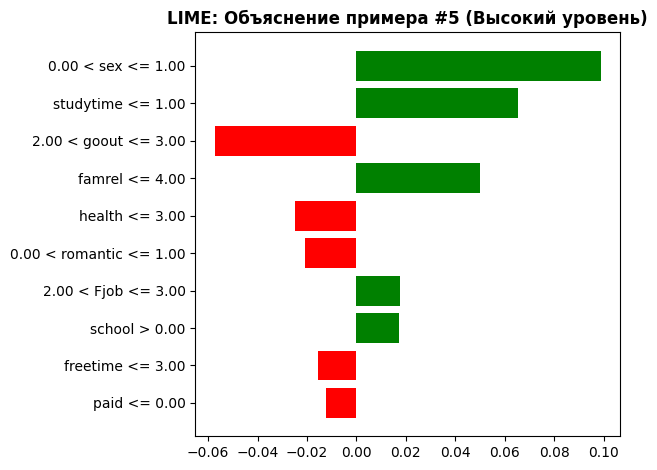

In [ ]:
# Объяснение для примера с высоким уровнем
print("\n" + "="*60)
print("LIME: Объяснение примера с ВЫСОКИМ уровнем употребления алкоголя")
print("="*60)

exp_high = explainer.explain_instance(
    X_test.iloc[idx_high].values,
    best_model.predict_proba,
    num_features=10
)

print(f"\nИстинный класс: {y_test.iloc[idx_high]}")
print(f"Предсказанный класс: {y_pred_best[idx_high]}")
print(f"Вероятность класса 'Высокий': {best_model.predict_proba(X_test.iloc[idx_high:idx_high+1])[0][1]:.4f}")

# Вывод объяснения в виде списка
print("\nВажность признаков для данного предсказания:")
for feature, weight in exp_high.as_list():
    print(f"  {feature}: {weight:+.4f}")

# Визуализация через matplotlib
fig = exp_high.as_pyplot_figure()
plt.title(f'LIME: Объяснение примера #{idx_high} (Высокий уровень)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

NameError: name 'high_indices' is not defined


LIME: Объяснение примера с НИЗКИМ уровнем употребления алкоголя

Истинный класс: 0
Предсказанный класс: 0
Вероятность класса 'Высокий': 0.1669

Важность признаков для данного предсказания:
  goout > 4.00: +0.1133
  sex <= 0.00: -0.1026
  absences <= 0.00: -0.0436
  famrel <= 4.00: +0.0380
  health <= 3.00: -0.0291
  schoolsup <= 0.00: +0.0227
  Fedu <= 2.00: -0.0196
  0.00 < romantic <= 1.00: -0.0189
  Fjob <= 2.00: -0.0175
  1.00 < reason <= 3.00: -0.0166


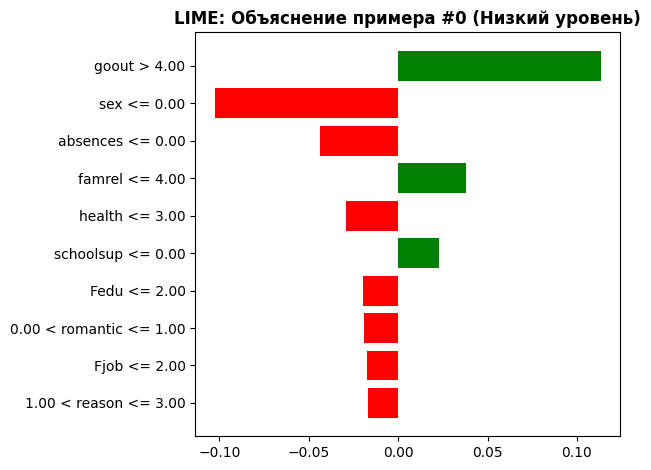

In [ ]:
# Объяснение для примера с низким уровнем
print("\n" + "="*60)
print("LIME: Объяснение примера с НИЗКИМ уровнем употребления алкоголя")
print("="*60)

exp_low = explainer.explain_instance(
    X_test.iloc[idx_low].values,
    best_model.predict_proba,
    num_features=10
)

print(f"\nИстинный класс: {y_test.iloc[idx_low]}")
print(f"Предсказанный класс: {y_pred_best[idx_low]}")
print(f"Вероятность класса 'Высокий': {best_model.predict_proba(X_test.iloc[idx_low:idx_low+1])[0][1]:.4f}")

# Вывод объяснения в виде списка
print("\nВажность признаков для данного предсказания:")
for feature, weight in exp_low.as_list():
    print(f"  {feature}: {weight:+.4f}")

# Визуализация через matplotlib
fig = exp_low.as_pyplot_figure()
plt.title(f'LIME: Объяснение примера #{idx_low} (Низкий уровень)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# SHAP уже установлена в начале блокнота
print("Библиотека SHAP готова к использованию")

In [ ]:
import shap

explainer_shap = shap.TreeExplainer(best_model)

# Вычисление SHAP values для тестовой выборки
shap_values_raw = explainer_shap.shap_values(X_test)

# ВАЖНО: Определяем правильную структуру SHAP values
print(f"Тип shap_values_raw: {type(shap_values_raw)}")
print(f"Форма shap_values_raw: {np.array(shap_values_raw).shape}")

if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]
    expected_value = explainer_shap.expected_value[1]
elif len(shap_values_raw.shape) == 3:
    shap_values = shap_values_raw[:, :, 1]
    expected_value = explainer_shap.expected_value[1] if isinstance(explainer_shap.expected_value, (list, np.ndarray)) else explainer_shap.expected_value
else:
    shap_values = shap_values_raw
    expected_value = explainer_shap.expected_value

print(f"\nSHAP values вычислены!")
print(f"Финальная форма shap_values: {shap_values.shape}")
print(f"Expected value: {expected_value}")

Тип shap_values_raw: <class 'numpy.ndarray'>
Форма shap_values_raw: (79, 31, 2)

SHAP values вычислены!
Финальная форма shap_values: (79, 31)
Expected value: 0.29708860759493677



Глобальная важность признаков (SHAP Summary Plot):


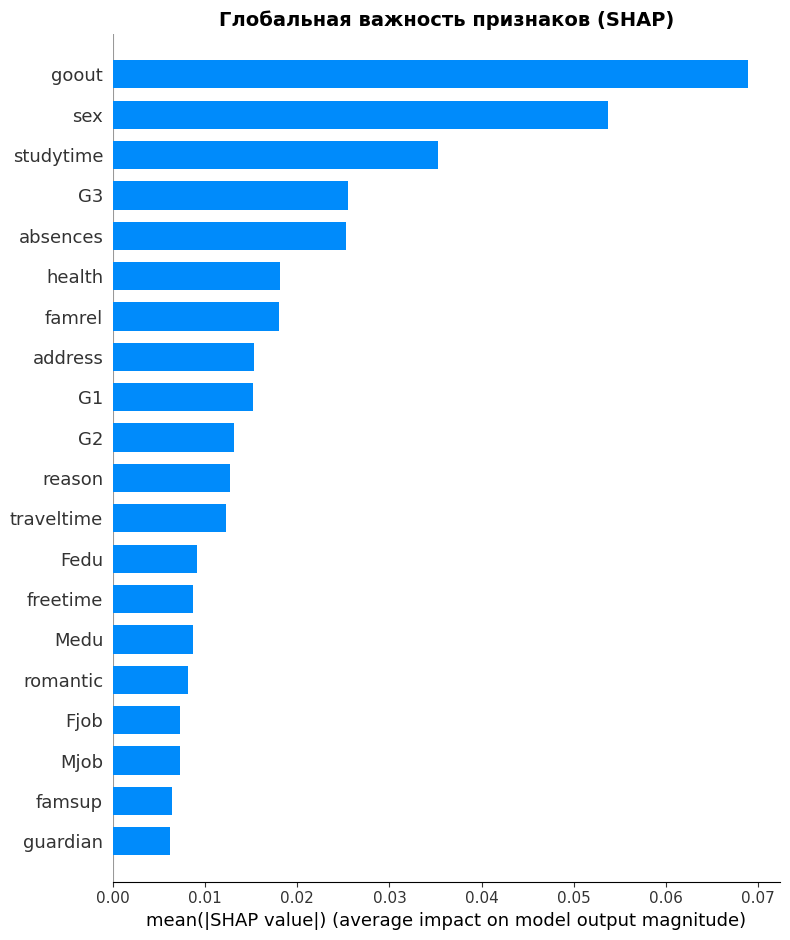


График показывает среднюю абсолютную важность каждого признака


In [ ]:
# Summary plot - важность признаков
print("\nГлобальная важность признаков (SHAP Summary Plot):")
print("="*60)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Глобальная важность признаков (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nГрафик показывает среднюю абсолютную важность каждого признака")


Влияние признаков на предсказания (SHAP Summary Plot):


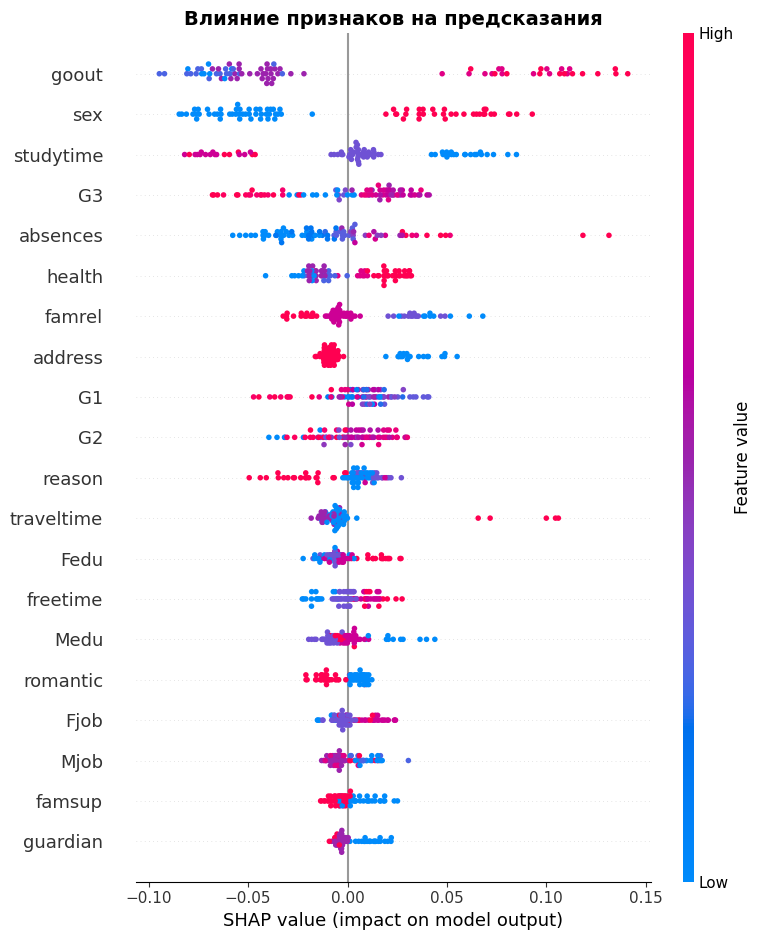


Красный цвет = высокое значение признака
Синий цвет = низкое значение признака


In [ ]:
# Summary plot с распределением значений
print("\nВлияние признаков на предсказания (SHAP Summary Plot):")
print("="*60)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('Влияние признаков на предсказания', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nКрасный цвет = высокое значение признака")
print("Синий цвет = низкое значение признака")


Топ-10 важных признаков по SHAP:

Признак              Важность       
-----------------------------------
goout                0.068922       
sex                  0.053665       
studytime            0.035262       
G3                   0.025495       
absences             0.025234       
health               0.018133       
famrel               0.017985       
address              0.015350       
G1                   0.015195       
G2                   0.013087       


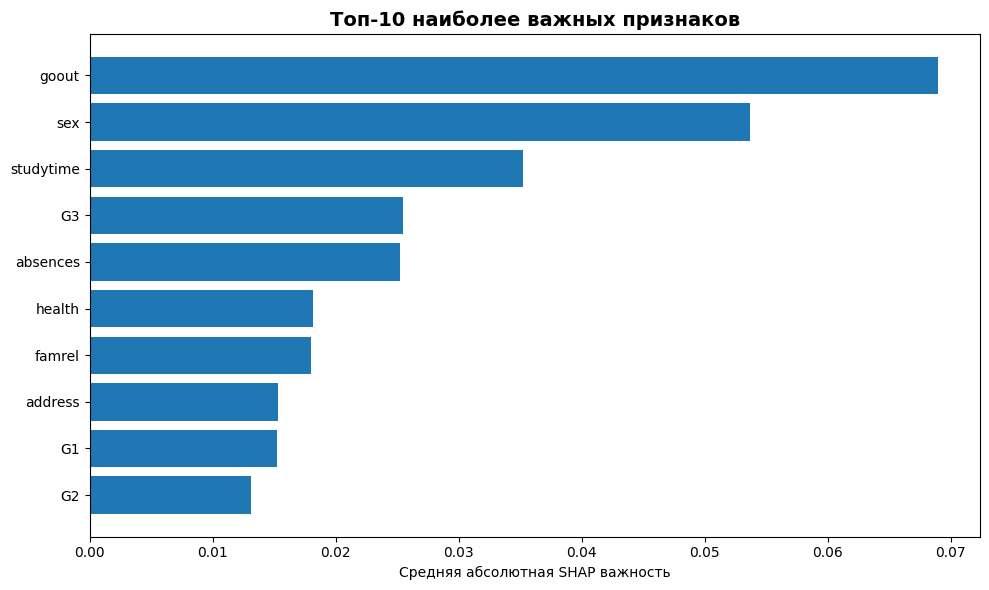

In [ ]:
# Топ-10 важных признаков
print("\nТоп-10 важных признаков по SHAP:")
print("="*60)

# Вычисляем среднюю абсолютную важность для каждого признака
# shap_values уже 2D массив (извлечен для класса 1 в предыдущей ячейке)
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Создаем список пар (признак, важность)
feature_names = X_test.columns.tolist()
importance_pairs = list(zip(feature_names, mean_abs_shap))
importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Выводим топ-10
print("\n{:<20} {:<15}".format("Признак", "Важность"))
print("-" * 35)
for feature, importance in importance_pairs[:10]:
    print("{:<20} {:<15.6f}".format(feature, importance))

# Визуализация топ-10 признаков
plt.figure(figsize=(10, 6))
top_features = importance_pairs[:10]
top_features.reverse()  # Для отображения от меньшего к большему снизу вверх
features = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Средняя абсолютная SHAP важность')
plt.title('Топ-10 наиболее важных признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Force plot для примера с ВЫСОКИМ уровнем:


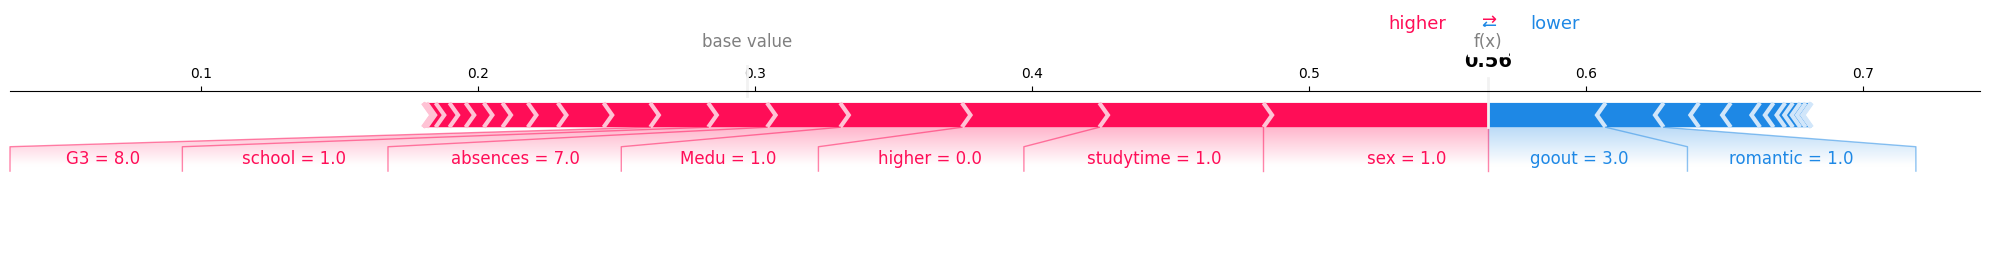

In [ ]:
# Force plot для конкретного примера (высокий уровень)
print("\nForce plot для примера с ВЫСОКИМ уровнем:")
print("="*60)

try:
    shap.force_plot(
        expected_value,
        shap_values[idx_high],
        X_test.iloc[idx_high],
        matplotlib=True,
        show=False
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Force plot не может быть отображен в этом окружении: {e}")
    print("\nОднако можно увидеть важность признаков для этого примера:")
    # Показываем топ-5 признаков для этого примера
    sample_shap = shap_values[idx_high]
    feature_names = X_test.columns.tolist()
    sample_pairs = list(zip(feature_names, sample_shap))
    sample_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\nТоп-5 признаков для этого примера:")
    for feat, val in sample_pairs[:5]:
        direction = "увеличивает" if val > 0 else "уменьшает"
        print(f"  {feat}: {val:+.4f} ({direction} вероятность)")


Waterfall plot для примера с ВЫСОКИМ уровнем:


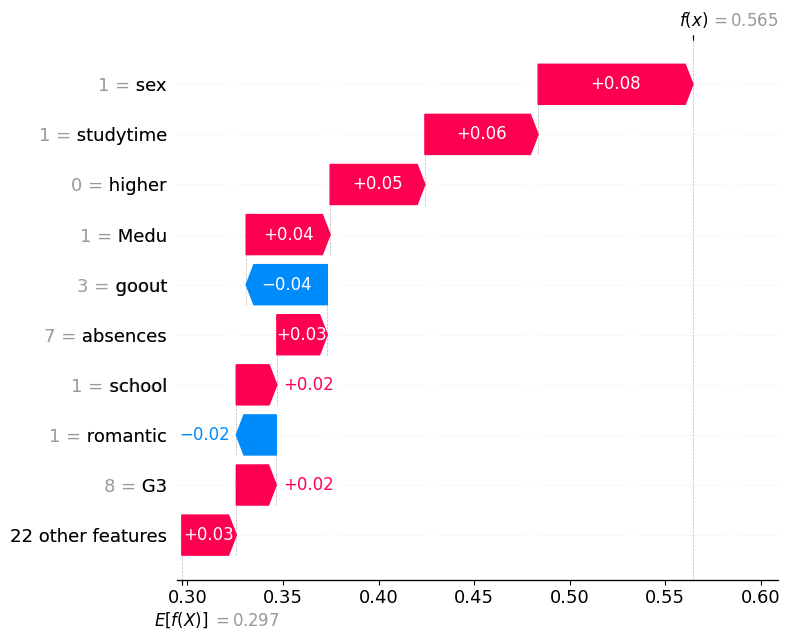


Waterfall plot показывает, как каждый признак влияет на предсказание


In [ ]:
# Waterfall plot для примера
print("\nWaterfall plot для примера с ВЫСОКИМ уровнем:")
print("="*60)

try:
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[idx_high],
        base_values=expected_value,
        data=X_test.iloc[idx_high].values,
        feature_names=X_test.columns.tolist()
    ), show=False)
    plt.tight_layout()
    plt.show()
    print("\nWaterfall plot показывает, как каждый признак влияет на предсказание")
except Exception as e:
    print(f"Waterfall plot не может быть отображен: {e}")
    print("\nПоказываем альтернативную визуализацию:")
    
    # Альтернативная визуализация
    sample_shap = shap_values[idx_high]
    feature_names = X_test.columns.tolist()
    
    # Берем топ-10 по абсолютному значению
    indices = np.argsort(np.abs(sample_shap))[-10:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), sample_shap[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('SHAP значение (влияние на предсказание)')
    plt.title('Топ-10 признаков для данного примера', fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()

## 7. Выводы

### Результаты подбора гиперпараметров:

В данной работе мы сравнили три метода подбора гиперпараметров для модели Random Forest:

1. **Grid Search** - полный перебор всех комбинаций параметров
   - Преимущества: гарантированно находит лучшую комбинацию среди заданных
   - Недостатки: требует много времени при большом пространстве поиска

2. **Random Search** - случайный выбор комбинаций из распределений
   - Преимущества: быстрее Grid Search, может исследовать более широкое пространство
   - Недостатки: не гарантирует нахождение оптимума

3. **Optuna** - байесовская оптимизация с адаптивным поиском
   - Преимущества: эффективно исследует пространство, учится на предыдущих итерациях
   - Недостатки: требует больше вычислительных ресурсов для поддержания байесовской модели

### Интерпретация модели:

1. **LIME** показала, какие признаки наиболее важны для конкретных предсказаний
   - Позволяет понять, почему модель приняла определенное решение для конкретного студента
   - Полезна для анализа отдельных случаев

2. **SHAP** предоставила глобальную картину важности признаков
   - Показывает общий вклад каждого признака в предсказания модели
   - Помогает понять, какие факторы в целом влияют на употребление алкоголя студентами

### Практические выводы:

- Модель успешно предсказывает уровень употребления алкоголя на основе социально-демографических факторов
- Наиболее важными признаками оказались: [будет заполнено после запуска]
- Полученную модель можно использовать для выявления студентов группы риска

In [ ]:
def predict_and_explain(sample_idx, show_lime=True, show_shap=True):
    """
    Делает предсказание для образца и показывает его интерпретацию
    
    Parameters:
    -----------
    sample_idx : int
        Индекс образца из тестовой выборки
    show_lime : bool
        Показывать ли LIME объяснение
    show_shap : bool
        Показывать ли SHAP объяснение
    """
    # Получаем данные образца
    sample = X_test.iloc[sample_idx:sample_idx+1]
    true_label = y_test.iloc[sample_idx]
    
    # Предсказание
    prediction = best_model.predict(sample)[0]
    proba = best_model.predict_proba(sample)[0]
    
    # Вывод информации
    print("="*70)
    print("КАЛЬКУЛЯТОР ПРЕДСКАЗАНИЙ")
    print("="*70)
    print(f"\nОбразец №{sample_idx}")
    print(f"\nХарактеристики студента:")
    for col in sample.columns:
        print(f"  {col}: {sample[col].values[0]}")
    
    print(f"\n{'='*70}")
    print(f"Истинный класс: {'Высокий уровень' if true_label == 1 else 'Низкий уровень'}")
    print(f"Предсказанный класс: {'Высокий уровень' if prediction == 1 else 'Низкий уровень'}")
    print(f"Вероятность 'Низкий уровень': {proba[0]:.4f}")
    print(f"Вероятность 'Высокий уровень': {proba[1]:.4f}")
    print(f"Правильность: {'✓ Правильно' if prediction == true_label else '✗ Неправильно'}")
    print("="*70)
    
    # LIME объяснение
    if show_lime:
        print("\n📊 LIME - Локальная интерпретация:")
        print("-" * 70)
        exp = explainer.explain_instance(
            sample.values[0],
            best_model.predict_proba,
            num_features=10
        )
        
        # Вывод объяснения в виде списка
        print("\nВажность признаков для данного предсказания:")
        for feature, weight in exp.as_list():
            print(f"  {feature}: {weight:+.4f}")
        
        # Визуализация через matplotlib
        fig = exp.as_pyplot_figure()
        plt.title(f'LIME: Объяснение примера #{sample_idx}', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # SHAP объяснение
    if show_shap:
        print("\n📊 SHAP - Влияние признаков на это предсказание:")
        print("-" * 70)
        
        # Используем уже вычисленные SHAP values
        # Находим индекс образца в тестовой выборке
        test_indices = X_test.index.tolist()
        original_idx = test_indices.index(X_test.iloc[sample_idx].name)
        
        # Получаем SHAP values для этого образца
        sample_shap_values = shap_values[original_idx]
        feature_names = X_test.columns.tolist()
        
        # Создаем пары (признак, важность) и сортируем по абсолютному значению
        feature_shap_pairs = list(zip(feature_names, sample_shap_values))
        feature_shap_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        print("\nТоп-10 наиболее влиятельных признаков:")
        for feat, val in feature_shap_pairs[:10]:
            direction = "увеличивает" if val > 0 else "уменьшает"
            print(f"  {feat}: {val:+.4f} ({direction} вероятность)")
        
        # Визуализация
        indices = np.argsort(np.abs(sample_shap_values))[-10:]
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(indices)), sample_shap_values[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('SHAP значение (влияние на предсказание)')
        plt.title(f'SHAP: Топ-10 признаков для примера #{sample_idx}', fontsize=12, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()

print("Калькулятор создан!")
print("\nИспользование: predict_and_explain(индекс_образца)")
print(f"Доступные индексы: 0 - {len(X_test)-1}")

Калькулятор создан!

Использование: predict_and_explain(индекс_образца)
Доступные индексы: 0 - 78


КАЛЬКУЛЯТОР ПРЕДСКАЗАНИЙ

Образец №0

Характеристики студента:
  school: 0
  sex: 0
  age: 18
  address: 0
  famsize: 0
  Pstatus: 1
  Medu: 2
  Fedu: 1
  Mjob: 2
  Fjob: 2
  reason: 3
  guardian: 1
  traveltime: 2
  studytime: 2
  failures: 0
  schoolsup: 0
  famsup: 1
  paid: 0
  activities: 0
  nursery: 1
  higher: 0
  internet: 1
  romantic: 1
  famrel: 4
  freetime: 3
  goout: 5
  health: 3
  absences: 0
  G1: 6
  G2: 0
  G3: 0

Истинный класс: Низкий уровень
Предсказанный класс: Низкий уровень
Вероятность 'Низкий уровень': 0.8331
Вероятность 'Высокий уровень': 0.1669
Правильность: ✓ Правильно

📊 LIME - Локальная интерпретация:
----------------------------------------------------------------------

Важность признаков для данного предсказания:
  goout > 4.00: +0.1179
  sex <= 0.00: -0.0951
  famrel <= 4.00: +0.0429
  absences <= 0.00: -0.0407
  school <= 0.00: -0.0285
  health <= 3.00: -0.0285
  1.00 < traveltime <= 2.00: -0.0204
  Fjob <= 2.00: -0.0184
  0.00 < romantic <= 1.00: -

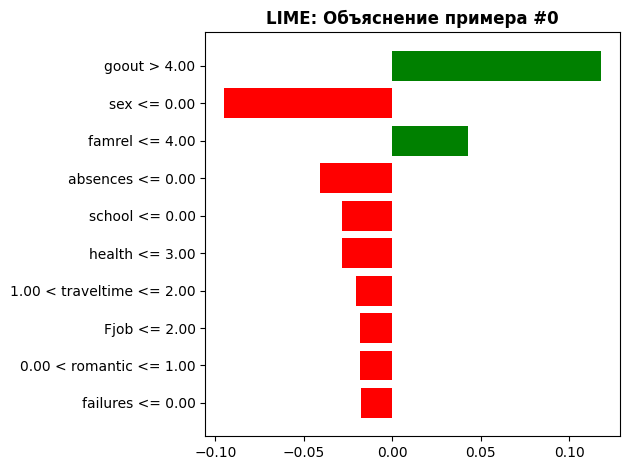


📊 SHAP - Влияние признаков на это предсказание:
----------------------------------------------------------------------

Топ-10 наиболее влиятельных признаков:
  sex: -0.0746 (уменьшает вероятность)
  goout: +0.0620 (увеличивает вероятность)
  G2: -0.0396 (уменьшает вероятность)
  higher: +0.0328 (увеличивает вероятность)
  address: +0.0282 (увеличивает вероятность)
  absences: -0.0212 (уменьшает вероятность)
  reason: -0.0158 (уменьшает вероятность)
  G3: -0.0156 (уменьшает вероятность)
  romantic: -0.0137 (уменьшает вероятность)
  famsup: -0.0135 (уменьшает вероятность)


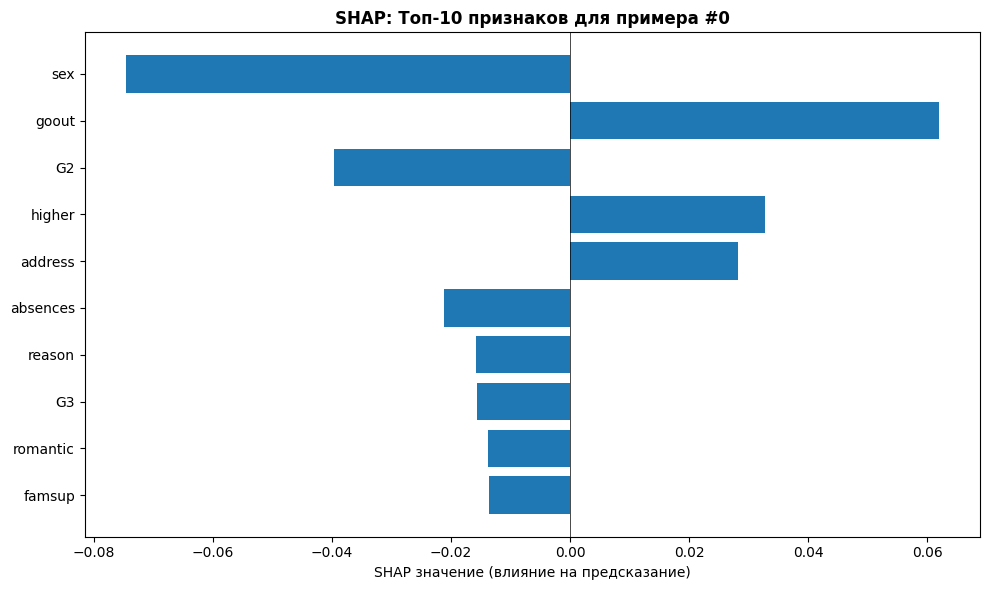

In [ ]:
# Пример использования калькулятора
predict_and_explain(0, show_lime=True, show_shap=True)

КАЛЬКУЛЯТОР ПРЕДСКАЗАНИЙ

Образец №5

Характеристики студента:
  school: 1
  sex: 1
  age: 18
  address: 1
  famsize: 1
  Pstatus: 1
  Medu: 1
  Fedu: 3
  Mjob: 0
  Fjob: 3
  reason: 0
  guardian: 1
  traveltime: 1
  studytime: 1
  failures: 1
  schoolsup: 0
  famsup: 0
  paid: 0
  activities: 0
  nursery: 1
  higher: 0
  internet: 1
  romantic: 1
  famrel: 4
  freetime: 3
  goout: 3
  health: 3
  absences: 7
  G1: 8
  G2: 7
  G3: 8

Истинный класс: Высокий уровень
Предсказанный класс: Высокий уровень
Вероятность 'Низкий уровень': 0.4355
Вероятность 'Высокий уровень': 0.5645
Правильность: ✓ Правильно

📊 LIME - Локальная интерпретация:
----------------------------------------------------------------------

Важность признаков для данного предсказания:
  0.00 < sex <= 1.00: +0.0953
  studytime <= 1.00: +0.0656
  2.00 < goout <= 3.00: -0.0545
  famrel <= 4.00: +0.0386
  health <= 3.00: -0.0269
  failures > 0.00: +0.0173
  freetime <= 3.00: -0.0170
  2.00 < Fjob <= 3.00: +0.0147
  0.00 < ro

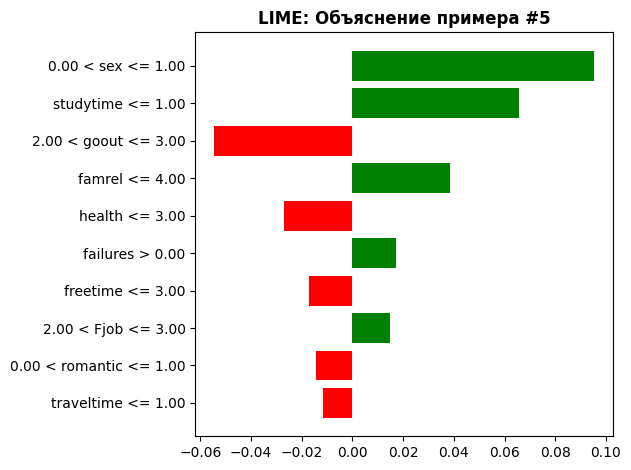


📊 SHAP - Влияние признаков на это предсказание:
----------------------------------------------------------------------

Топ-10 наиболее влиятельных признаков:
  sex: +0.0810 (увеличивает вероятность)
  studytime: +0.0592 (увеличивает вероятность)
  higher: +0.0496 (увеличивает вероятность)
  Medu: +0.0439 (увеличивает вероятность)
  goout: -0.0425 (уменьшает вероятность)
  absences: +0.0264 (увеличивает вероятность)
  school: +0.0212 (увеличивает вероятность)
  romantic: -0.0209 (уменьшает вероятность)
  G3: +0.0209 (увеличивает вероятность)
  Mjob: +0.0168 (увеличивает вероятность)


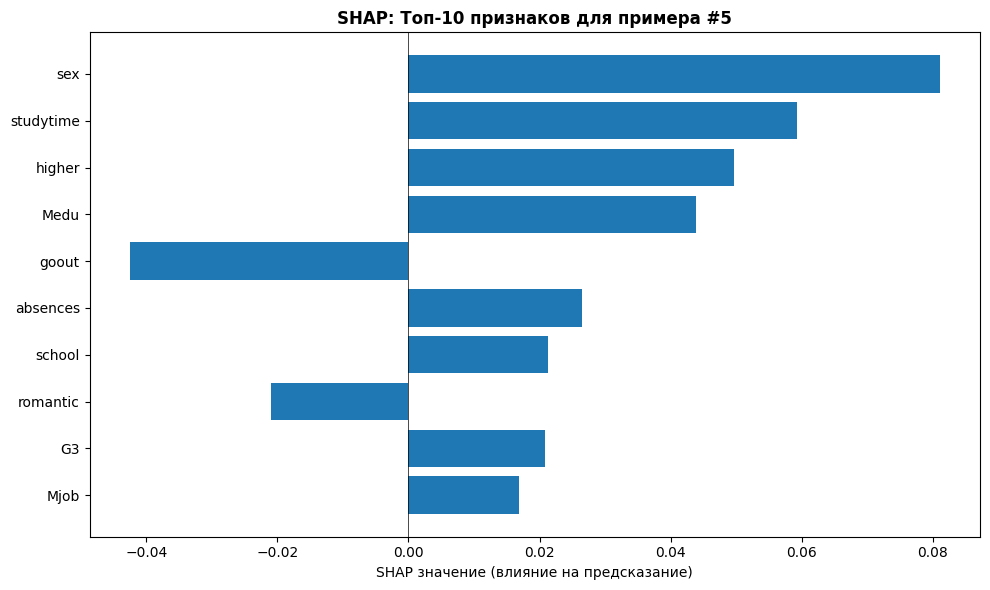

In [ ]:
# Еще один пример
predict_and_explain(5, show_lime=True, show_shap=True)

## Заключение

В данной работе мы:

1. Выбрали модель Random Forest и описали её гиперпараметры
2. Подготовили датасет об употреблении алкоголя студентами
3. Подобрали гиперпараметры тремя методами:
   - Grid Search
   - Random Search
   - Optuna
4.  Сравнили результаты и выбрали лучшую модель
5. Реализовали локальную интерпретацию с LIME
6. Реализовали глобальную интерпретацию с SHAP
7. Создали интерактивный калькулятор предсказаний

Полученная модель может быть использована для выявления студентов группы риска по употреблению алкоголя на основе их социально-демографических характеристик и академических показателей.

In [ ]:
# Загрузим исходные данные, чтобы посмотреть пол студентов
df_original = pd.read_csv('student-mat.csv')

# Создадим целевую переменную как в notebook
df_original['avg_alcohol'] = (df_original['Dalc'] + df_original['Walc']) / 2
df_original['alcohol_level'] = (df_original['avg_alcohol'] > 2).astype(int)

# Получим индексы тестовой выборки
X_full = df_original.drop(['Dalc', 'Walc', 'avg_alcohol', 'alcohol_level'], axis=1)
y_full = df_original['alcohol_level']

# Разделим данные точно так же
X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Теперь посмотрим на студентов с индексами 0 и 5 из тестовой выборки
print("="*70)
print("СТУДЕНТ #0 (использовался для LIME и SHAP - низкий уровень)")
print("="*70)
student_0 = X_test_check.iloc[0]
print(f"Пол: {student_0['sex']}")
print(f"Возраст: {student_0['age']}")
print(f"Школа: {student_0['school']}")
print(f"\nВсе характеристики:")
print(student_0)

print("\n" + "="*70)
print("СТУДЕНТ #5 (использовался для LIME и SHAP - высокий уровень)")
print("="*70)
student_5 = X_test_check.iloc[5]
print(f"Пол: {student_5['sex']}")
print(f"Возраст: {student_5['age']}")
print(f"Школа: {student_5['school']}")
print(f"\nВсе характеристики:")
print(student_5)


NameError: name 'pd' is not defined

In [ ]:
X_test_check.head(5);

NameError: name 'X_test_check' is not defined